# Chapter 9 향후 판매량 예측

[Predict Future Sales competition link](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data)  
[탐색적 데이터 분석 코드 참고 링크](https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda)

# 9.1 경진대회 이해
---

### 🔍 학습 목표

- EDA는 간단하게 다룰 예정
- 다양한 피처 엔지니어링 기법


### 🔍 학습 키워드  

- 유형 및 평가지표: 회귀, RMSE
- EDA: 데이터 병합, 그룹화
- 머신러닝 모델: LightGBM
- 피처 엔지이너링: 피처명 한글화, 데이터 다운캐스팅, 조합, 이어붙이기, 병합, 이상치 제거, 파생 피처 생성


### 🔍 데이터 설명

|데이터|내용|
|:---|:---|
|sales_train.csv|2023년 1월~ 2015년 10월 일별 판매 내역|
|test.csv|테스트 데이터|
|sample_submission.csv|샘플 제출 파일|
|items.csv|상품 정보|
|item_categories.csv|상품 분류 정보|
|shops.csv|상점 정보|


### 🔍 주의 사항  

- 각 상점읜 상품별 판매량 즉 타깃값은 0에서 20개 사이여야 함
- 시계열 데이터이므로 가장 최근인 2015년 10월 판매 내역을 검증 데이터로 사용할 예정

# 9.2 탐색적 데이터 분석  
---

## 9.2.1 데이터 둘러보기

In [1]:
import numpy as np
import pandas as pd

import time as time
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import warnings

warnings.filterwarnings(action='ignore')

# 데이터 경로 지정
data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [2]:
# version checking

print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(lgb.__version__)

2.2.3
1.26.4
0.12.2
4.2.0


### 🔍 `sales_train` 데이터

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# sales_train 내 월을 구분짓는 컬럼 date_block_num의 유니크 값 개수
sales_train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

- 월별 판매량이 필요하므로 date 피처는 제거하고 월 구분자만 남기도록 함 : date_block_num 컬럼이 월을 차례대로 구분지어주고 있음

In [5]:
## 상점별 아이템별 가격의 unique 값 갯수
sales_train.groupby(['shop_id','item_id'])['item_price'].nunique().sort_values(ascending = False).head(10)

shop_id  item_id
12       11373      427
         11369      344
         11370      335
31       17717      288
27       17717      229
42       17717      209
12       11365      207
7        17717      177
6        17717      173
12       13753      151
Name: item_price, dtype: int64

- 동일한 물건에 대해서 판매 가격이 달라질 수 있음

In [6]:
## 상점별 상품별 월별 판매 수량 합계
sales_train.groupby(['shop_id', 'item_id','date_block_num'])['item_cnt_day'].sum()

shop_id  item_id  date_block_num
0        30       1                 31.0
         31       1                 11.0
         32       0                  6.0
                  1                 10.0
         33       0                  3.0
                                    ... 
59       22164    27                 2.0
                  30                 1.0
         22167    9                  1.0
                  11                 2.0
                  17                 1.0
Name: item_cnt_day, Length: 1609124, dtype: float64

In [7]:
## 상점별 아이템별 판매기간
sales_train.groupby(['shop_id', 'item_id'])['date_block_num'].count()

shop_id  item_id
0        30          9
         31          7
         32         11
         33          6
         35         12
                    ..
59       22154       1
         22155       1
         22162      16
         22164       6
         22167       4
Name: date_block_num, Length: 424124, dtype: int64

In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


- item_cnt_day의 값은 판매 수량이므로 월별 판매량은 상점의 상품별 일일 판매량을 월별로 합쳐야 **각 상점의 상품별 월간 판매량**
- 타깃값 : date_block_num 피처 값이 같은 데이터들의 item_cnt_day 값의 합

In [9]:
sales_train.info(show_counts=True)  # 비결측값 개수를 표기하는 옵션

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


- 모든 데이터에 결측값이 없는 정돈된 데이터
- 메모리가 134MB 정도로 메모리 관리 필요

### 🔍 `shops` 데이터

In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


- `shop_name` 컬럼의 첫 단어를 추출해 피처를 만들 예정: 현재 데이터에서 상점명의 첫 단어는 상점이 위치한 도시를 나타냄  
- `shop_id` 컬럼을 key로 train 데이터에 병합 가능  

In [11]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


- 상점은 60개로 결측값 없음

### 🔍 `items` 데이터

In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


- `item_name` 컬럼은 제거 예정: 상품명에서는 유용한 정보를 얻기 힘듦  
- `item_id` 컬럼을 key로 train 데이터에 병합 가능  

In [13]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


- 상품은 22,170개로 결측값 없음

### 🔍 `item_categories` 데이터

In [14]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


- `item_category_name` 컬럼의 첫 단어를 추출해 피처를 만들 예정: 첫 단어는 대분류를 뜻함  
- `item_category_id` 컬럼을 key로 items 데이터에 이어 train 데이터에 병합 가능  

In [15]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


- 상품 분류는 84개로 결측값 없음

### 🔍 `test` 데이터

In [16]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


- 식별자인 id, shop_id, item_id로 각 상점의 상품별 월간 판매량이 y

### 🔍 데이터 병합: 병합 데이터 variable `train`

In [17]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


### 🔍 피처 요약표 만들기


In [18]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    
    return summary

resumetable(train)

데이터 세트 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


- id와 name 둘 중 하나만 있어도 됨: 상점, 상품, 상품 분류의 id와 name 고윳값 개수가 동일하므로 1:1 관계

## 9.2.2 데이터 시각화

### 🔍 일별 판매량

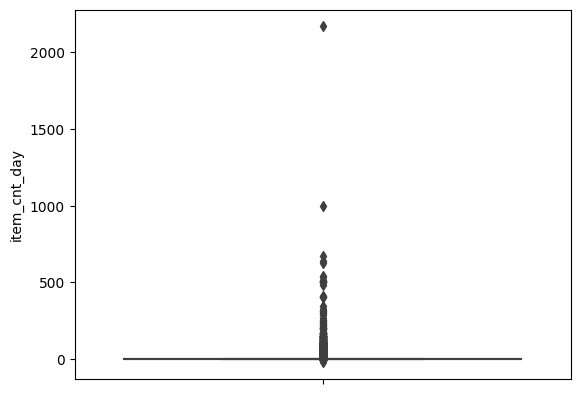

In [19]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=train);

- 1000 이상의 데이터를 제거할 계획

### 🔍 상품 가격

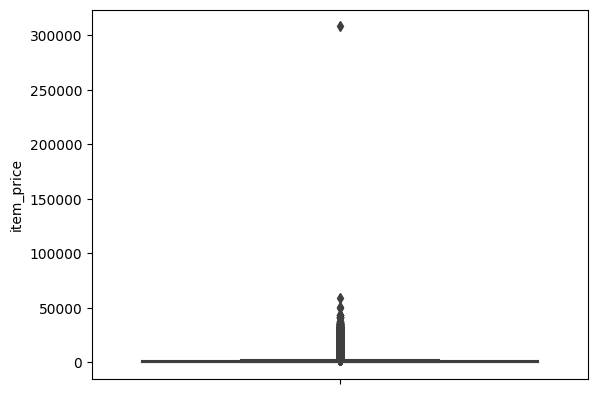

In [20]:
sns.boxplot(y='item_price', data=train);

- 50000 이상의 데이터를 제거할 계획

### 🔍 그룹화

월 별 월간 판매량: `date_block_num` 피처를 기준으로 그룹화 하여 `item_cnt_day` 피처 값을 구하는 코드

In [21]:
group = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


#### `groupby()`에 적용할 수 있는 집계 함수 예시

- 결측값이 모든 값에 대한 집계

|함수|의미|
|---|---|
|sum|합|
|mean|평균|
|median|중간값|
|std|표준편차|
|var|분산|
|count|개수|
|min|최솟값|
|max|최댓값|


### 🔍 월별 판매량

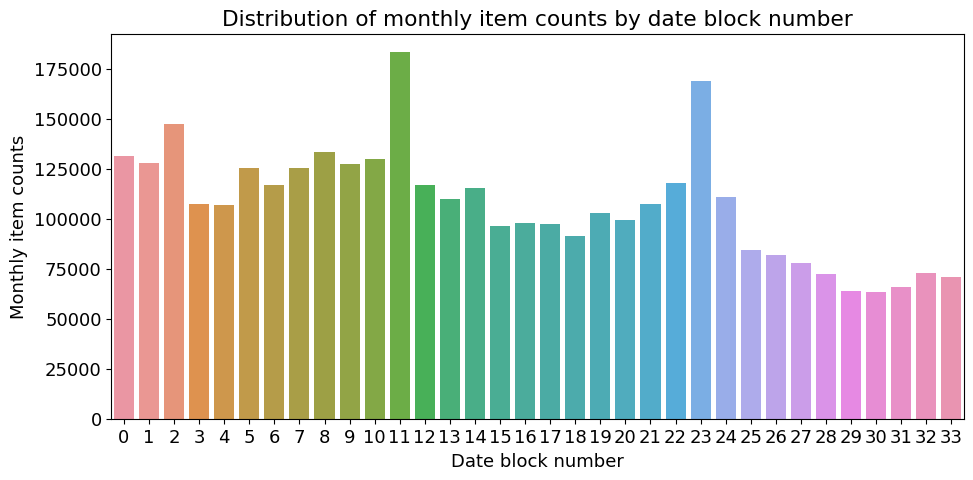

In [22]:
mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)

# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

- 12월에 판매량이 높음: 11과 23이 각각 2013년 12월과 2014년 12월로 급증세를 보임

### 🔍 상품분류별 판매량

판매량이 10000개를 초과하는 상품에 대해서만 상품 분류별 판매량 탐색

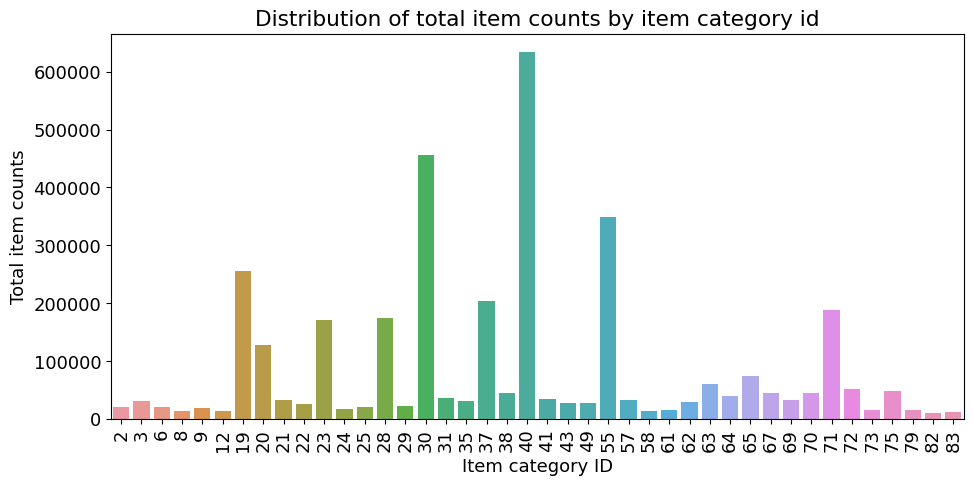

In [23]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 총 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 상품분류별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

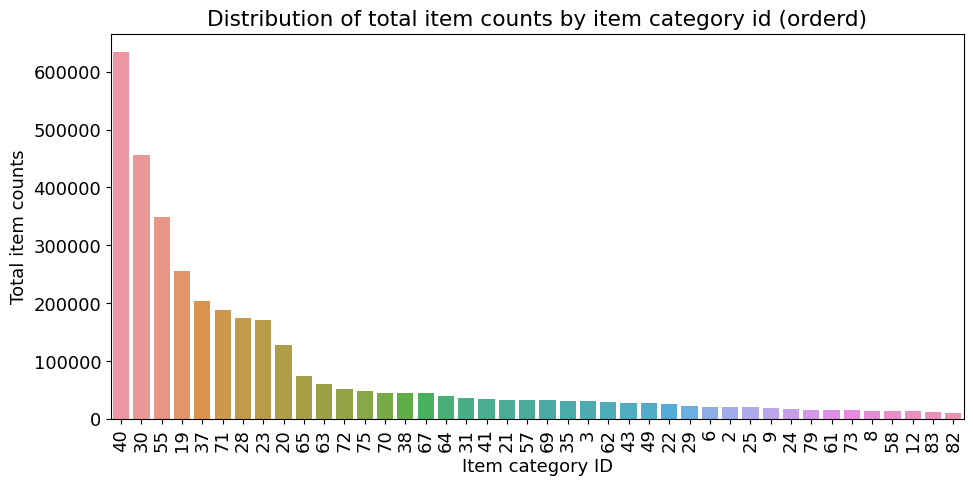

In [24]:
# 내림차순
# y값 내림차순 정렬 및 xtick order로 활용
group_cat_sum1 = group_cat_sum.sort_values(by='item_cnt_day', ascending=False)
group_cat_sum1['item_category_id'] = group_cat_sum1['item_category_id'].astype(str)

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum1, order=group_cat_sum1['item_category_id'], ax=ax)
ax.set(title='Distribution of total item counts by item category id (orderd)',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

- id 40, 30, 35 등의 순서로 판매량이 높음

### 🔍 상점별 판매량

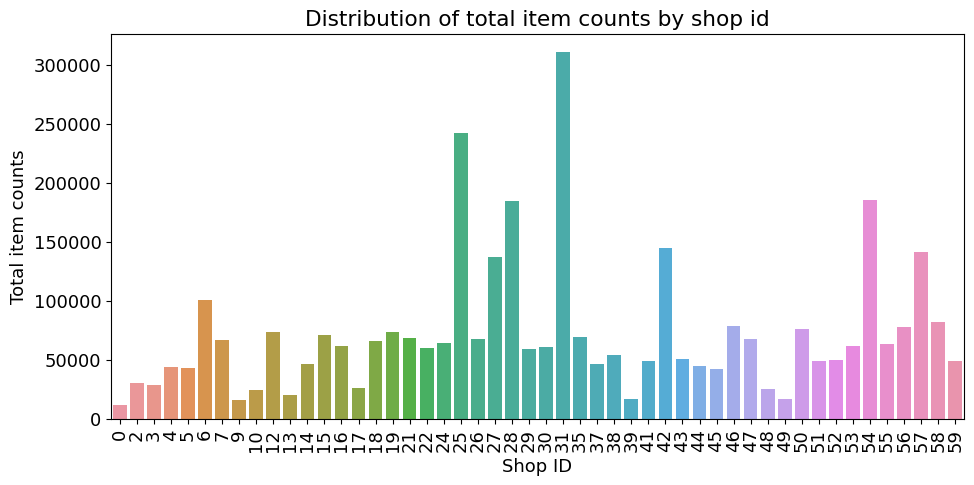

In [25]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 상품 판매량 막대그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

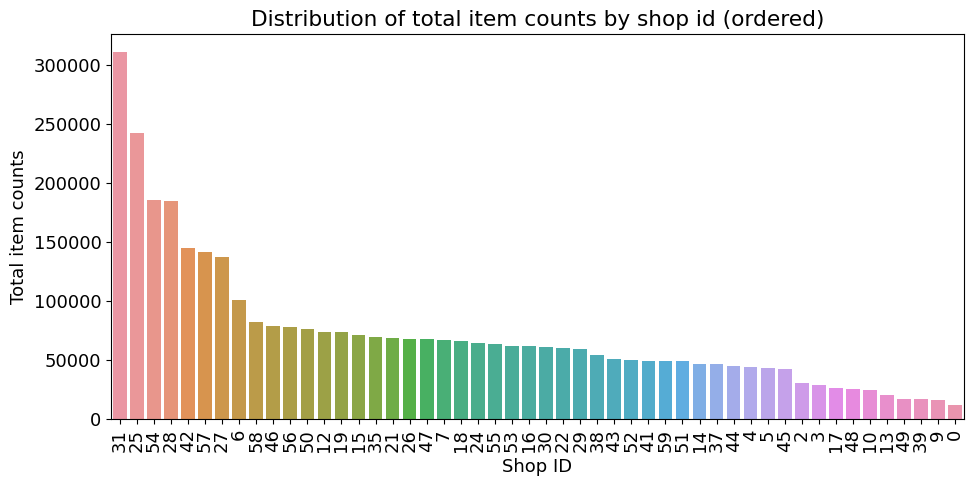

In [26]:
# 내림차순
group_shop_sum1 = group_shop_sum.sort_values(by='item_cnt_day', ascending=False)
group_shop_sum1['item_category_id'] = group_shop_sum1['shop_id'].astype(str)

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum1, order=group_shop_sum1['shop_id'], ax=ax)
ax.set(title='Distribution of total item counts by shop id (ordered)',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

- 일부 7~8개의 상점이 다른 상점들 보다 판매량이 높음

---


### ➕ 10000개 이하의 상품은?

상점별로 취급 물건이 다를까, 상품 분류를 보고 상점을 추정할 수 있을까...  
매출이 적은 상품들을 가진 상점들의 sales는 어떨까

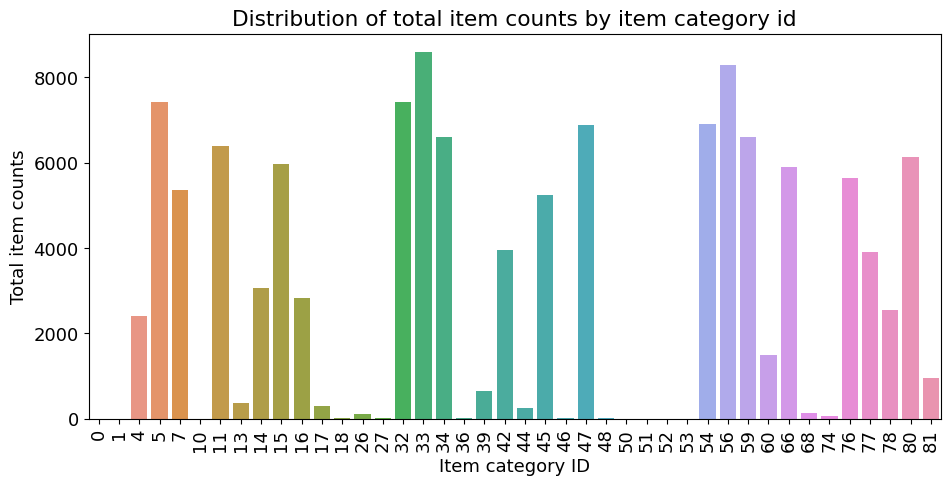

In [27]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] < 10000]

# 상품분류별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

- 상품: 10000 이하에서도 판매량이 극히 적은 카테고리가 존재함  

#### ➕➕ 적은 상품들의 평균 가격

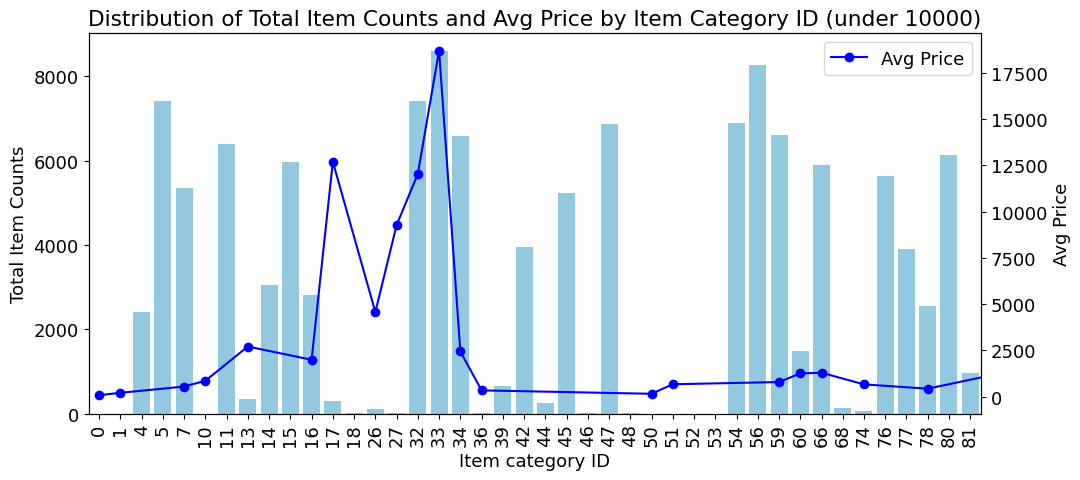

In [28]:
# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] < 10000]
# 상품분류별 평균 상품 가격
group_cat_mean = train[train['item_category_id'].isin(group_cat_sum['item_category_id'].unique())].groupby('item_category_id').agg({'item_price': 'mean'})
group_cat_mean = group_cat_mean.reset_index()

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# barplot- 상품분류별 총 상품 판매량
sns.barplot(
    x='item_category_id',
    y='item_cnt_day',
    data=group_cat_sum,
    color='skyblue',
    ax=ax
)

# lineplot- 상품분류별 평균 가격
ax2 = ax.twinx()  # 동일한 x축을 공유하는 새로운 y축 생성
ax2.plot(
    group_cat_mean['item_category_id'],
    group_cat_mean['item_price'],
    color='blue',
    marker='o',
    linestyle='-',
    label='Avg Price'
)

# x축 범위를 데이터의 최소값과 최대값으로 설정
ax.set_xlim(-0.5, len(group_cat_sum) - 0.5)

# 제목 및 범례
ax.set(title='Distribution of Total Item Counts and Avg Price by Item Category ID (under 10000)',
       xlabel='Item category ID', 
       ylabel='Total Item Counts')
ax2.set(ylabel='Avg Price')

# x축 레이블 회전
ax.tick_params(axis='x', labelrotation=90)
# 꺾은선 그래프에 범례 추가
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### ➕ 10000개 이하의 상점은?

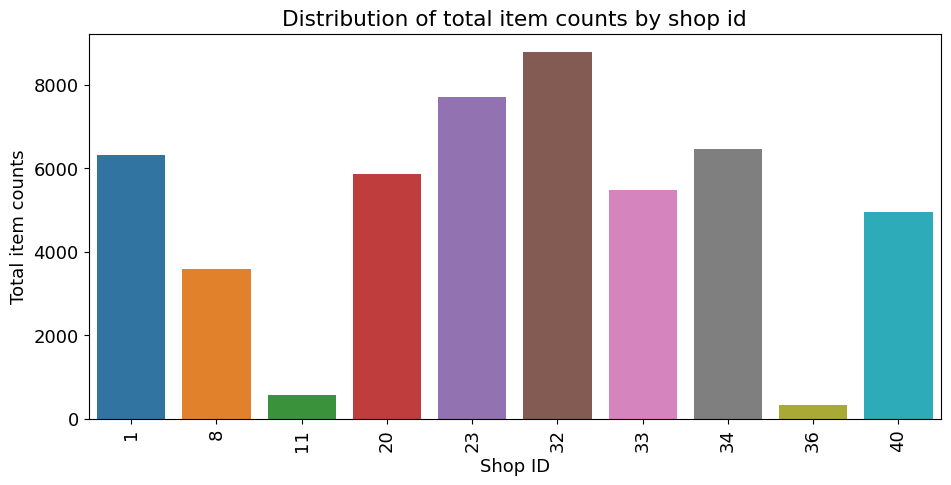

In [29]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] < 10000]

# 상점별 총 상품 판매량 막대그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)


- 상점: 10000 이하에서도 판매량이 적은 상점이 존재함
  - 적은 이유 추측: 생긴지 오래 안됐거나, 취급하는 카테고리가 다른 상점과 다를지 궁금

### ➕➕ 11, 36 점포

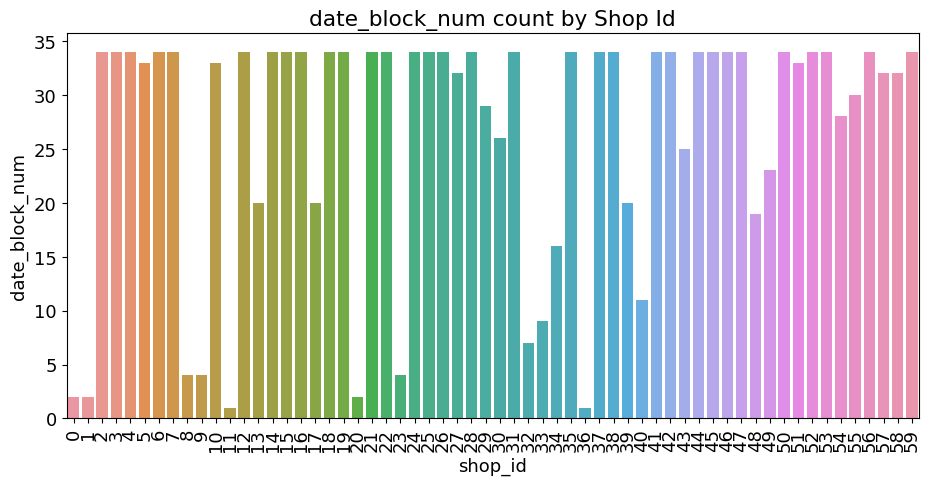

In [30]:
# 상점별 date_block_num
df_1 = train.groupby('shop_id').nunique('date_block_num')
df_1 = df_1.reset_index()

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)
sns.barplot(x='shop_id', y='date_block_num', data=df_1, order=df_1['shop_id'], ax=ax)
ax.set(title='date_block_num count by Shop Id')
ax.tick_params(axis='x', labelrotation=90)

- 적었던 11, 36번 점포가 date_block_num이 극히 적은 것을 알 수 있음

In [31]:
# date_block_num 찾기
df_1 = train[train['shop_id'].isin([11, 36])]
df_1['date_block_num'].nunique()

2

- 11번 36번 점포의 date_block_num이 각각 1개씩으로, 어떤 가게에 대해서는 시계열의 의미가 없는 경우도 있음을 확인



### ➕ 전체 카테고리별 평균 가격

카테고리별로 가격의 차이가 있을까, 판매량이 많은 상품은 가격이 어떨까

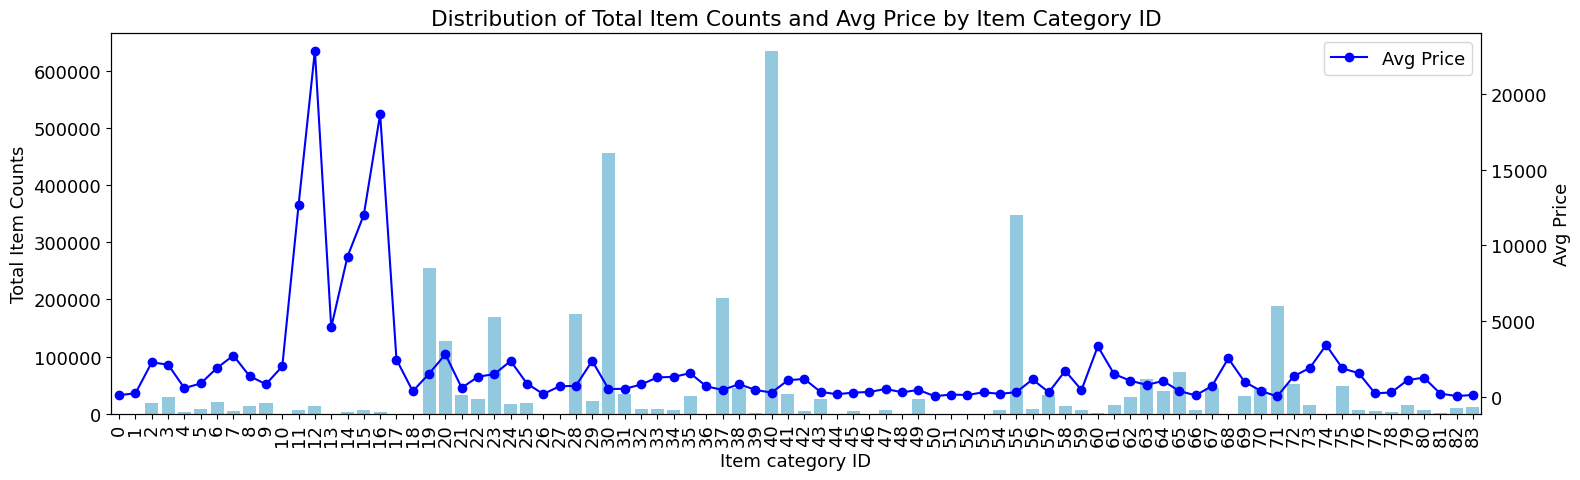

In [32]:
# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()
# 상품분류별 평균 상품 가격
group_cat_mean = train.groupby('item_category_id').agg({'item_price': 'mean'})
group_cat_mean = group_cat_mean.reset_index()

figure, ax = plt.subplots()
figure.set_size_inches(16, 5)

# barplot- 상품분류별 총 상품 판매량
sns.barplot(
    x='item_category_id',
    y='item_cnt_day',
    data=group_cat_sum,
    color='skyblue',
    ax=ax
)

# lineplot- 상품분류별 평균 가격
ax2 = ax.twinx()  # 동일한 x축을 공유하는 새로운 y축 생성
ax2.plot(
    group_cat_mean['item_category_id'],
    group_cat_mean['item_price'],
    color='blue',
    marker='o',
    linestyle='-',
    label='Avg Price'
)

# x축 범위를 데이터의 최소값과 최대값으로 설정
ax.set_xlim(-0.5, len(group_cat_sum) - 0.5)

# 제목 및 범례
ax.set(title='Distribution of Total Item Counts and Avg Price by Item Category ID',
       xlabel='Item category ID', 
       ylabel='Total Item Counts')
ax2.set(ylabel='Avg Price')

# x축 레이블 회전
ax.tick_params(axis='x', labelrotation=90)
# 꺾은선 그래프에 범례 추가
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

- 높은 판매량일 수록 낮은 가격대를 형성하고 있는 것으로 보임

### ➕ 전체 상점별 평균 매출

상점별로 상품의 팡매량과 매출과 비슷할까

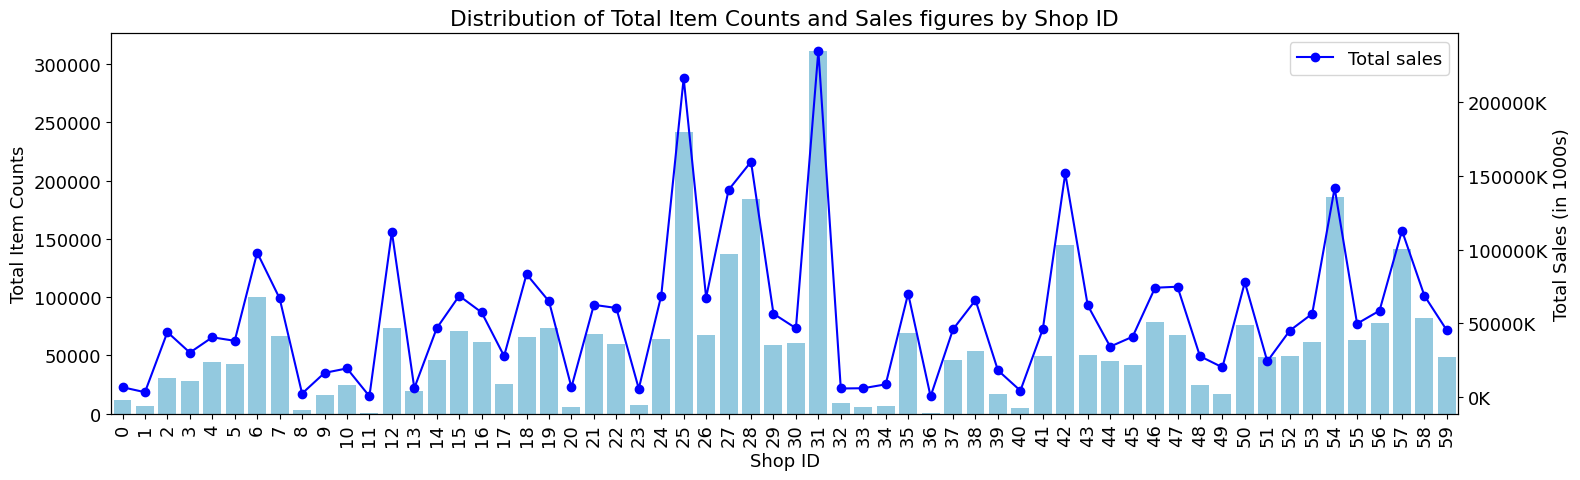

In [33]:
# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()
# 상점별 총 매출
train['sales'] = train['item_price'] * train['item_cnt_day']
group_shop_salessum = train.groupby('shop_id').agg({'sales': 'sum'})
group_shop_salessum = group_shop_salessum.reset_index()

figure, ax = plt.subplots()
figure.set_size_inches(16, 5)

# barplot- 상점별 총 상품 판매량
sns.barplot(
    x='shop_id',
    y='item_cnt_day',
    data=group_shop_sum,
    color='skyblue',
    ax=ax
)

# lineplot- 상점별 총 매출
ax2 = ax.twinx()
ax2.plot(
    group_shop_salessum['shop_id'],
    group_shop_salessum['sales'],
    color='blue',
    marker='o',
    linestyle='-',
    label='Total sales'
)

# x축 범위를 데이터의 최소값과 최대값으로 설정
ax.set_xlim(-0.5, len(group_shop_sum) - 0.5)

# 제목 및 범례
ax.set(title='Distribution of Total Item Counts and Sales figures by Shop ID',
       xlabel='Shop ID', 
       ylabel='Total Item Counts')

# 천 단위 수정
from matplotlib.ticker import FuncFormatter
# y축 포맷팅 설정
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
# y축 레이블 설정
ax2.set_ylabel('Total Sales (in 1000s)')

# x축 레이블 회전
ax.tick_params(axis='x', labelrotation=90)
# 꺾은선 그래프에 범례 추가
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

- 이상치를 제거하지 않았음에도 판매량과 sales는 어느정도 비례하는 것을 보아, 가격은 비교적 작지만 판매량이 많은 카테고리에 따라 매출이 결정되는 것으로 추측됨

</br>

### 🔑 분석 정리

- 파생 피처 추가: 상점명과 상품 분류 명의 첫 단어로 추가 예정  
- 피처 제거: 월별 판매량이 필요하므로 date 컬럼 삭제  
  - 상점id, 상품id, 상품 분류id는 각각의 name과 매칭되므로 둘 중 하나만 남김  
- 이상치 제거: 일별 판매량과 판매가에 이상치 존재하므로 삭제 필요

### 🔑 모델링 전략

- 베이스라인 모델: LightGBM  
  - 피처 엔지니어링: 피처명 한글화, 데이터 다운캐스팅, 데이터 조합 생성, 타깃값 추가
- 성능 개선: LightGBM  
  - 피처 엔지니어링: 이상치 제거, 전처리, 파생피처 추가, 인코딩, 결측값 처리


# 9.3 Baseline Model
---

- 순서
  1. 피처명 한글화
  2. 데이터 다운캐스팅
  3. 데이터 조합 생성
  4. 파생 피처 추가
  5. 테스트 데이터 붙이기
  6. 이외 상점, 상품, 상품 분류 데이터 병합
  7. train, validation, test 데이터 만들기



## 🔍 9.3.1 피처 엔지니어링 I : 피처명 한글화

In [34]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [35]:
shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [36]:
items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [37]:
item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [38]:
test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## 🔍 9.3.2 피처 엔지니어링 II : 데이터 다운캐스팅

- pandas의 `info(memory_usage = 'deep')` 를 이용해 데이터프레임의 **실제** 메모리 확인 가능

### data downcasting  
- 더 작은 데이터 타입으로 변환하는 작업
- 진행 전 데이터의 min, max를 알아두는 것이 좋음  
- 범위에 맞춰 type을 줄여주되, 연산이 필요한 컬럼은 많이 늘어나기도 하니 범위를 넓게 잡아주는 것이 좋음  
- object type을 category type 혹은 datetime type으로 변경하는 것만으로도 용량 절약 가능  
- [참조](https://hoonnam0424.tistory.com/2)  
  

In [39]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   날짜      object 
 1   월ID     int64  
 2   상점ID    int64  
 3   상품ID    int64  
 4   판매가     float64
 5   판매량     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [40]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    print(df.info(memory_usage = 'deep'), "\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   날짜      object 
 1   월ID     int64  
 2   상점ID    int64  
 3   상품ID    int64  
 4   판매가     float64
 5   판매량     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 299.6 MB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상점명     60 non-null     object
 1   상점ID    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 10.7 KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     22170 non-null  object
 1   상품ID    22170 non-null  int64 
 2   상품분류ID  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.9 MB
None 




In [41]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [42]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

54.2% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


In [43]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    print(df.info(memory_usage = 'deep'), "\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   날짜      object 
 1   월ID     int8   
 2   상점ID    int8   
 3   상품ID    int16  
 4   판매가     float64
 5   판매량     int16  
dtypes: float64(1), int16(2), int8(2), object(1)
memory usage: 226.8 MB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상점명     60 non-null     object
 1   상점ID    60 non-null     int8  
dtypes: int8(1), object(1)
memory usage: 10.3 KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     22170 non-null  object
 1   상품ID    22170 non-null  int16 
 2   상품분류ID  22170 non-null  int8  
dtypes: int16(1), int8(1), object(1)
memory usage

## 🔍 9.3.3 피처 엔지니어링 III : 데이터 조합 생성

- 예측해야하는 데이터는 월-상점-상품의 판매량이므로 해당 조합 생성  
- 데이터가 없는 것은 0으로 간주  

In [44]:
from itertools import product

train = []
# 월id, 상점id, 상품id 조합 생성 
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
# 리스트 타입 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


## 🔍 9.3.4 피처 엔지니어링 IV : 타깃값(월간 판매량) 추가

- 타깃값은 각 상점의 상품별 월간 판매량이므로 groupby를 이용하여 월간 판매량 집계  

In [45]:
# 앞서 조합을 만들면서 사용한 idx_features 활용
# idx_features를 기준으로 그룹화하여 판매량 sum 
group = sales_train.groupby(idx_features).agg({'판매량': 'sum'})
group = group.reset_index()

# 피처명을 '판매량'에서 '월간 판매량'으로 변경
group = group.rename(columns={'판매량': '월간 판매량'})

group

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [46]:
# train과 group 병합
train = train.merge(group, on=idx_features, how='left')

train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


- 메모리 절약을 위해 `group` 처럼 더 이상 필요하지 않은 영역을 해제하는 가비지 컬렉션 수행

In [47]:
import gc # 가비지컬렉터 불러오기

del group # 더는 사용하지 않는 변수 지정
gc.collect();

## 🔍 9.3.5 피처 엔지니어링 V : 테스트 데이터 이어붙이기

- shops, items, items_categories 데이터 이어붙일 시 편하도록 준비
- 현재 monthnum은 33까지 있고, 테스트 데이터는 이어지는 2015년 11월 판매기록이므로 `34`로 설정

In [48]:
test['월ID'] = 34

In [49]:
# train, test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, # 기존 인덱스 무시(0부터 새로 시작)
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

In [50]:
# 결측값 0으로 대체
all_data = all_data.fillna(0)
all_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0


## 🔍 9.3.6 피처 엔지니어링 VI : 나머지 데이터 병합(최종 데이터 생성)

- 상점, 상품, 상품 분류 데이터 병합

In [51]:
# merge shops, items, item_categories data
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# data downcasting
all_data = downcast(all_data)

# garbage collection
del shops, items, item_categories
gc.collect();

31.1% 압축됨


In [52]:
# 확인
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,상점명,상품명,상품분류ID,상품분류명
0,0,59,22154,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


- 상점명, 상품명, 상품분류명 drop

In [53]:
all_data = all_data.drop(['상점명', '상품명', '상품분류명'], axis=1)

## 🔍 9.3.7 피처 엔지니어링 VII : 마무리

- 월 기준으로 훈련, 검증, 테스트 데이터 분리
- 타깃값은 최대 20이어야 하므로 0 ~ 20로 제한  

In [54]:
# feature
# train data
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# validation data
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# test data
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# target
# train data
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
y_train = y_train.clip(0, 20)
# validation data
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']
y_valid = y_valid.clip(0, 20)

In [55]:
del all_data
gc.collect();

## 🦾 9.3.8 모델 훈련 및 성능 검증

- **LightGBM** 활용  
- 기본 파라미터만 설정  
- 상점, 상품, 상품 분류가 범주형  
  - 상품은 고윳값 개수가 많으므로 범주형으로 취급 X  
  - 상점과 상품 분류만 categorical_feature 파라미터에 전달함  


### LightGBM
- 리프 중심의 트리 확장 방식  
- 범주형 피쳐를 인코딩 없이 처리 가능  
- Random Foorest와 달리 부스팅을 사용하여 순차적 학습  
- XBGoost에 비해 학습 속도가 빠르고 메모리 사용량이 적음  

In [56]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse',  # 평가지표: RMSE
          'num_leaves': 255,
          'learning_rate': 0.01,
          'force_col_wise': True,
          'random_state': 10}

# categorical 피처 설정
cat_features = ['상점ID', '상품분류ID']

# LightGBM train, val 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)


# LightGBM 모델 훈련

# 50회 반복마다 검증지표 출력(verbose_eval 파라미터 대체)
callbacks = [lgb.log_evaluation(period=50)]

lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=500,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      callbacks=callbacks) # verbose_eval 대체
                      # verbose_eval=50 # 3.3.0 버전 이후 제공하지 않습니다.

[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 4
[LightGBM] [Info] Start training from score 0.299125
[50]	training's rmse: 1.14777	valid_1's rmse: 1.06755
[100]	training's rmse: 1.11425	valid_1's rmse: 1.0386
[150]	training's rmse: 1.09673	valid_1's rmse: 1.02671
[200]	training's rmse: 1.08573	valid_1's rmse: 1.02027
[250]	training's rmse: 1.07722	valid_1's rmse: 1.01661
[300]	training's rmse: 1.0698	valid_1's rmse: 1.0138
[350]	training's rmse: 1.06317	valid_1's rmse: 1.01084
[400]	training's rmse: 1.05734	valid_1's rmse: 1.00936
[450]	training's rmse: 1.05224	valid_1's rmse: 1.00818
[500]	training's rmse: 1.04792	valid_1's rmse: 1.00722


## 🦾 9.3.9 예측 및 결과 제출

In [57]:
# predict
preds = lgb_model.predict(X_test).clip(0, 20)

In [58]:
# generate a submission file
submission['item_cnt_month'] = preds
submission.to_csv('submission-baseline.csv', index=False)

In [ ]:
# 메모리 사용 최적화를 위해 factory reset하거나 아래 코드 실행해주세요!
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

# 9.4 성능 개선
---

- 개별 데이터 피처 엔지니어링: 전처리, 파생 피처 생성, 인코딩
- 데이터 조합 생성 후 파생 피처 추가
- 테스트 데이터 이어붙인 뒤 위에서 피처 엔지니어링한 데이터 병합
- 시차 피처 생성

## 🔍 9.4.1 피처 엔지니어링 I : 피처명 한글화와 데이터 다운캐스팅

- 베이스라인에서 진행했던 부분 일부 수행

In [108]:
# 위에서 메모리 정리를 했기 때문에 데이터를 일부 다시 불러옵니다.
data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [109]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [110]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

54.2% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


## 🔍 9.4.2 피처 엔지니어링 II : 개별 데이터 피처 엔지니어링

### 🔑 `sales_train` 이상치 제거 및 전처리

- 이상치 제거: 판매가와 판매량이 음수인 경우 환불이거나 오류이므로 이상치로 간주
- 판매가 50000 이상, 판매량 1000 이상인 경우 이상치로 간주

In [111]:
# 판매가가 0보다 큰 데이터 추출
sales_train = sales_train[sales_train['판매가'] > 0]
# 판매가가 50,000보다 작은 데이터 추출
sales_train = sales_train[sales_train['판매가'] < 50000]

# 판매량이 0보다 큰 데이터 추출
sales_train = sales_train[sales_train['판매량'] > 0]
# 판매량이 1,000보다 작은 데이터 추출
sales_train = sales_train[sales_train['판매량'] < 1000]

- 같은 상점이나 상점명이 조금 다른 상점들을 상점으로 취급
- 상점 id만 사용할 것이므로 id만 수정

In [112]:
# 상점명 확인 코드
print(shops['상점명'][0], '||', shops['상점명'][57])
print(shops['상점명'][1], '||', shops['상점명'][58])
print(shops['상점명'][10], '||', shops['상점명'][11])
print(shops['상점명'][39], '||', shops['상점명'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [113]:
# sales_train 데이터에서 상점ID 수정
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 수정
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

### 🔑 `shops` 파생 피처 생성 및 인코딩

- 상점명 앞부분을 가져와 `도시` 피처 생성
- 상점명의 오탈자 제거
- 레이블 인코딩 진행
- 상점명 피처 제거

In [114]:
shops['도시'] = shops['상점명'].apply(lambda x: x.split()[0])

In [115]:
# 도시 확인 
shops['도시'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [116]:
# "!" 가 존재하는 부분 오류 제거
shops.loc[shops['도시'] =='!Якутск', '도시'] = 'Якутск'

In [117]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 도시 피처 레이블 인코딩
shops['도시'] = label_encoder.fit_transform(shops['도시'])

In [118]:
# 상점명 피처 drop
shops = shops.drop('상점명', axis=1)
shops.head()

,상점ID,도시
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### 🔑 `itmes` 파생 피처 생성

- items 데이터의 상품명 drop
- sales_train 데이터 내 판매 데이터를 이용하여 첫 판매월 피처 구하여 생성
  - 첫 판매월이 결측인 값들이 존재: 판매된 적이 없는 상품
  - 처음 팔린 달을 2015년 11월(test)이라고 가정: 11월 판매량만 예측하면 되기 때문(테스트 데이터에 없는 상품이면 고려대상이 아니게 되기 때문)

In [119]:
# 상품명 피처 drop
items = items.drop(['상품명'], axis=1)

In [120]:
# 상품이 맨 처음 팔린 날을 피처로 추가
items['첫 판매월'] = sales_train.groupby('상품ID').agg({'월ID': 'min'})['월ID']
items.head()

,상품ID,상품분류ID,첫 판매월
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


In [121]:
items[items['첫 판매월'].isna()]

,상품ID,상품분류ID,첫 판매월
83,83,40,NaN
140,140,45,NaN
168,168,44,NaN
173,173,45,NaN
204,204,44,NaN
...,...,...,...
21974,21974,61,NaN
21975,21975,61,NaN
22022,22022,40,NaN
22035,22035,40,NaN


In [122]:
# 첫 판매월 피처의 결측값을 34로 대체
items['첫 판매월'] = items['첫 판매월'].fillna(34)

### 🔑 `item_categories` 파생 피처 생성 및 인코딩

- 상품 분류 name에서 대분류라는 파생 피처를 만들고 인코딩 (첫 단어 추출)
- 상품 분류 고윳값 개수 자체가 적은 경우 etc로 묶음
- 레이블 인코딩을 진행한 뒤 상품분류명 피처 drop

In [123]:
# 상품분류명의 첫 단어를 대분류로 추출
item_categories['대분류'] = item_categories['상품분류명'].apply(lambda x: x.split()[0])  

In [124]:
# 각 첫 단어 고윳값 개수 출력
item_categories['대분류'].value_counts()

대분류
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [125]:
def make_etc(x):
    if len(item_categories[item_categories['대분류']==x]) >= 5:
        return x
    else:
        return 'etc'

# 대분류의 고윳값 개수가 5개 미만이면 'etc'로 바꾸기
item_categories['대분류'] = item_categories['대분류'].apply(make_etc)

In [126]:
# 확인
item_categories.head()

,상품분류명,상품분류ID,대분류
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [127]:
# label encoder
label_encoder = LabelEncoder()

# 대분류 피처 label encoding
item_categories['대분류'] = label_encoder.fit_transform(item_categories['대분류'])

# 상품분류명 피처 drop
item_categories = item_categories.drop('상품분류명', axis=1)

## 🔍 9.4.3 피처 엔지니어링 III : 데이터 조합 및 파생 피처 생성

### 🔑 데이터 조합

- 베이스라인과 동일

In [128]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
train = pd.DataFrame(np.vstack(train), columns=idx_features)

### 🔑 파생 피처 생성

- 월, 상점, 상품 정보로 월간 판매량에 추가로 **평균 판매가** 피처 생성
  - 결측의 경우 판매량과 판매가가 0인 것에 대해 0으로 대체 예정
- 판매 여부에 관련된 피처 생성

In [129]:
group = sales_train.groupby(idx_features).agg({'판매량': 'sum',
                                               '판매가': 'mean'})
group = group.reset_index()
group = group.rename(columns={'판매량': '월간 판매량', '판매가': '평균 판매가'})

train = train.merge(group, on=idx_features, how='left')
train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [130]:
import gc
# group 변수 가비지 컬렉션
del group
gc.collect();

- 기준 피처별 상품 판매 건수: 당일에 한 번이라도 판매를 했다면 1, 판매가 없없다면 0

In [131]:
# 상품 판매건수 피처 추가
group = sales_train.groupby(idx_features).agg({'판매량': 'count'})
group = group.reset_index()
group = group.rename(columns={'판매량': '판매건수'})

train = train.merge(group, on=idx_features, how='left')

# 가비지 컬렉션
del group, sales_train
gc.collect()

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


## 🔍 9.4.4 피처 엔지니어링 IV : 데이터 합치기

### 🔑 테스트 데이터 이어붙이기

- 테스트 데이터 이어붙인 되 `shop`, `items`, `item_categories` 데이터를 `sales_train`에 병합

In [132]:
# 테스트 데이터 월ID를 34로 설정
test['월ID'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


### 🔑 모든 데이터 병합

In [133]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

# 가비지 컬렉션
del shops, items, item_categories
gc.collect();

68.9% 압축됨


## 🔍 9.4.5 피처 엔지니어링 V : 시차 피처 생성


- 시차 피처(time lag feature)  
  - 과거 시점에 대한 관한 피처
  - 시계열 문제에서 성능 향상에 주로 쓰임

- 시차 피처 생성
  - 기준으로 삼을 치러 생성: 이번 문제의 경우 `월간 평균 판매량`
  - 이를 위해 '기준 피처별 월간 평균 판매량' 피처 생성 필요


### 🔑 기준 피처별 월간 평균 판매량 파생 피처 생성  
  
- 파라미터
  - `df` : 작업할 전체 데이터 프레임
  - `mean_features` : 새로 만든 월간 평균 판매량 파생 피처명을 저장할 리스트
  - `idx_features` : 기준 피처


In [134]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처의 첫번째 요소가 '월id'가 맞는지 확인 
    assert (idx_features[0] == '월ID') and \
           len(idx_features) in [2, 3]
    
    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'
    
    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'월간 판매량': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량': feature_name})
    
    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)
    
    # 가비지 컬렉션
    del group
    gc.collect()
    
    return df, mean_features

- 함수를 활용하여 `월-상품`인 것과 `월-상품-도시`로 그룹화한 월간 평균 판매량을 만듦
- `item_mean_features`: 기준 피처에 상품 id를 포함하는 파생피처명

In [135]:
# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID', '도시'])

In [136]:
# 확인
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

- 월별 상점별 상품분류의 월간 판매량 피처 생성

In [137]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['월ID', '상점ID', '상품분류ID'])

In [138]:
# 확인
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

### 🔑 시차 피처 생성 원리 및 함수 구현

- '징검다리 피처' 라고 표현: 원하는 시점까지 생성할 수 있으나, 시점이 너무 과거면 예측력이 떨어질 수 있음
- 따라서 세 달 전까지만 활용  


- 파라미터
  - `df` : 원본 데이터
  - `lag_features_to_clip` : 값의 범위를 0~20 사이로 제한할 피처를 담을 리스트로, 판매량 관련 피처가 해당
  - `idx_features` : 기준 피처
  - `lag_feature` : 시차를 만들 피처
  - **`nlags` : 시차**
    - 1 = 한 달 전
    - 2 = 한 달 전, 두 달 전 시차 피처 생성
    - 3 = 한 달, 두 달, 세 달 전 피처 생성
  - `clip` : 새로 만든 시차 피처를 `lag_features_to_clip` 리스트(0~20으로 값을 제한할 피처)에 저장할지의 여부로 boolean

In [139]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, 
                     nlags=3, 
                     clip=False):
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사 
    df_temp = df[idx_features + [lag_feature]].copy() 

    # 시차 피처 생성 
    for i in range(1, nlags+1):
        # 시차 피처명 
        lag_feature_name = lag_feature +'_시차' + str(i)
        # df_temp 열 이름 설정 
        df_temp.columns = idx_features + [lag_feature_name]
        # df_temp의 date_block_num 피처에 1 더하기
        df_temp['월ID'] += 1
        # idx_feature를 기준으로 df와 df_temp 병합하기 
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # 결측값 0으로 대체 
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가 
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # 데이터 다운캐스팅
    df = downcast(df, False)
    # 가비지 컬렉션
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

### 🔑 시차 피처 생성 I : 월간 판매량

- 월, 상점, 상품을 기준으로 세 달치의 시차 피처 생성
- `clip = True`로 `lag_features_to_clip`에 저장

In [140]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='월간 판매량', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [141]:
# 확인
all_data.head().T

,0,1,2,3,4
월ID,0.000000,0.000000,0.000000,0.000000,0.000000
상점ID,59.000000,59.000000,59.000000,59.000000,59.000000
상품ID,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
월간 판매량,1.000000,0.000000,0.000000,0.000000,0.000000
평균 판매가,999.000000,0.000000,0.000000,0.000000,0.000000
판매건수,1.000000,0.000000,0.000000,0.000000,0.000000
도시,30.000000,30.000000,30.000000,30.000000,30.000000
상품분류ID,37.000000,58.000000,58.000000,56.000000,59.000000
첫 판매월,0.000000,0.000000,0.000000,0.000000,0.000000
대분류,5.000000,7.000000,7.000000,7.000000,7.000000


In [142]:
# 저장 확인
lag_features_to_clip

['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']

### 🔑 시차 피처 생성 II : 판매건수, 평균 판매가

- 판매건수와 평균 판매가의 시차 피처 생성 
- 0~20 사이의 제한이 필요 없음 : `clip` 파라미터 생략

In [143]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='판매건수', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='평균 판매가', 
                                                  nlags=3)

### 🔑 시차 피처 생성 III : 평균 판매량

- 이미 리스트에 저장된 '상품별 평균 판매량', '상품별 도시별 평균 판매량'에 대해 시차 피처 생성
  - 시차 피처 생성 후 제거
- 평균 판매량 피처 `item_mean_features` 를 활용하여 시차 피처 생성


In [144]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

- 월별 상점별 상품분류의 월간 판매량 피처 `shop_mean_feature` 기준으로 시차 피처 생성

In [145]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['월ID', '상점ID', '상품분류ID'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

### 🔑 시차 피처 생성 마무리 : 결측값 처리

- 월 id가 0, 1, 2인 데이터에 대해 결측이 생김: 3달 치의 시차 피처를 만들었기 때문
- 이 결측치에 대해 월 id가 3 미만인 데이터 drop 결정

In [146]:
# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['월ID'] < 3].index)

## 🔍 9.4.6 피처 엔지니어링 VI : 기타 피처 엔지니어링

### 🔑 기타 피처 추가  
- 월간 판매량 시차 피처들의 평균
- 시차 변화량
- 신상 여부
- 월(month)
- 첫 판매 후 경과 기간

#### 추가로  
- 필요 없는 피처 제거

#### 1. 월간 판매량 시차 피처들의 평균

In [147]:
all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1',
                                          '월간 판매량_시차2', 
                                          '월간 판매량_시차3']].mean(axis=1)

In [148]:
# 결과에 대해 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)

#### 2. 시차 변화량

- 시차 데이터간 변화량을 구하여 무한대/소는 결측 처리 뒤 0으로 대체

In [149]:
all_data['시차변화량1'] = all_data['월간 판매량_시차1']/all_data['월간 판매량_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['월간 판매량_시차2']/all_data['월간 판매량_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

#### 3. 신상 여부

- 첫 판매월이 현재 월과 같은지 여부 피처 생성

In [150]:
all_data['신상여부'] = all_data['첫 판매월'] == all_data['월ID']

#### 4. 첫 판매 후 경과 기간

- 첫 판매 후 얼마나 지났는지 계산 피처 생성

In [151]:
all_data['첫 판매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']

#### 5. 월(month)

In [152]:
all_data['월'] = all_data['월ID'] % 12

## 🔍9.4.7 피처 엔지니어링 VII : 마무리

In [153]:
# data 살펴보기
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9904582 entries, 1122386 to 11026967
Data columns (total 34 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int16  
 4   평균 판매가                   float64
 5   판매건수                     int8   
 6   도시                       int8   
 7   상품분류ID                   int8   
 8   첫 판매월                    int8   
 9   대분류                      int8   
 10  월간 판매량_시차1               int16  
 11  월간 판매량_시차2               int16  
 12  월간 판매량_시차3               int16  
 13  판매건수_시차1                 int8   
 14  판매건수_시차2                 int8   
 15  판매건수_시차3                 int8   
 16  평균 판매가_시차1               float64
 17  평균 판매가_시차2               float64
 18  평균 판매가_시차3               float64
 19  상품ID별 평균 판매량_시차1         float32
 20  상품ID별 평균 판매량_시차2         float32
 21  상

*- 어디선가의 문제로 30개가 아닌 33개의 컬럼이 출력되어 맞지 않는 부분 일부 drop 하고 다운캐스팅을 진행합니다.*

In [154]:
all_data = all_data.drop(['평균 판매가', '판매건수', '첫 판매월'], axis=1)
downcast(all_data, False) # 출력 X
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9904582 entries, 1122386 to 11026967
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int8   
 4   도시                       int8   
 5   상품분류ID                   int8   
 6   대분류                      int8   
 7   월간 판매량_시차1               int8   
 8   월간 판매량_시차2               int8   
 9   월간 판매량_시차3               int8   
 10  판매건수_시차1                 int8   
 11  판매건수_시차2                 int8   
 12  판매건수_시차3                 int8   
 13  평균 판매가_시차1               float64
 14  평균 판매가_시차2               float64
 15  평균 판매가_시차3               float64
 16  상품ID별 평균 판매량_시차1         float32
 17  상품ID별 평균 판매량_시차2         float32
 18  상품ID별 평균 판매량_시차3         float32
 19  상품ID 도시별 평균 판매량_시차1      float32
 20  상품ID 도시별 평균 판매량_시차2      float32
 21  상

In [155]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']

# 가비지 컬렉션
del all_data
gc.collect();

## 🦾 9.4.8 모델 훈련 및 성능 검증

- 베이스라인 모델과 동일

In [159]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation # 버전차이로 지원하지 않는 부분 설정

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse',  # 평가지표: RMSE
          'num_leaves': 255,
          'learning_rate': 0.005,  # 이전 학습율 0.01
          'feature_fraction': 0.75,  # 추가1
          'bagging_fraction': 0.75,  # 추가2
          'bagging_freq': 5,  # 추가3
          'force_col_wise': True,
          'random_state': 10}

# categorical 피처 설정 : 도시, 대분류, 월 추가
cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)


# LightGBM 모델 훈련

# 100회 반복마다 검증지표 출력(verbose_eval 파라미터 대체)
# early_stopping_rounds=150 대체 추가
callbacks = [log_evaluation(period=100),  # verbose_eval 대체
            early_stopping(stopping_rounds=150)]  # early_stopping_rounds 대체

lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,  # 이전 학습: 500
                      valid_sets=(dtrain, dvalid),
                      # early_stopping_rounds=150, # v4.0.0 이후 지원하지 않습니다
                      categorical_feature=cat_features,
                      callbacks=callbacks) # verbose_eval, early_stopping_rounds 대체
                      # verbose_eval=100 # v3.3.0 이후 제공하지 않습니다. 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 9452298, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.297707
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01073	valid_1's rmse: 0.986993
[200]	training's rmse: 0.909083	valid_1's rmse: 0.922887
[300]	training's rmse: 0.857505	valid_1's rmse: 0.898233
[400]	training's rmse: 0.829175	valid_1's rmse: 0.888136
[500]	training's rmse: 0.810627	valid_1's rmse: 0.884038
[600]	training's rmse: 0.796874	valid_1's rmse: 0.882521
[700]	training's rmse: 0.786792	valid_1's rmse: 0.88237
[800]	training's rmse: 0.778925	valid_1's rmse: 0.882124
[900]	training's rmse: 0.772394	valid_1's rmse: 0.881969
[1000]	training's rmse: 0.766875	valid_1's rmse: 0.881747
[1100]	training's rmse: 0.7

## 🦾 9.4.9 예측 및 결과 제출


In [160]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)

In [161]:
# 제출 파일 생성
submission['item_cnt_month'] = preds
submission.to_csv('submission-engineered.csv', index=False)

In [ ]:
# 추가로 이어서 할 경우 reset시 사용하세요.
# del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
# gc.collect();